In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import pickle

In [2]:
aspDf = pd.read_csv("aspect_classification/aspect_classification_data_v2.csv")

for row in aspDf.iterrows():
    row = row[1]
    row["trg"] = row["trg"].lower()
    
aspDf = aspDf.drop_duplicates("trg")

In [3]:
aspDf.reset_index(drop=True, inplace=True)

In [4]:
aspDf.to_csv("aspect_classification/aspect_classification_data_v2.csv", index=None)

In [3]:
# For v1.
for row in aspDf.iterrows():
    row = row[1]
    row["cat"] = row["cat"].split("#")[0]

aspDf = aspDf[aspDf["cat"]!="DRINKS"]
aspDf.loc[aspDf["cat"]=="LOCATION", "cat"] = "RESTAURANT"

In [5]:
aspDf.cat.unique()

array(['PLACE', 'SERVICE', 'FOOD', 'PRICE', 'AMBIENCE'], dtype=object)

In [7]:
# Adding price category. v2 already includes it.
prices = ["ante", "charge", "cost", "damage", "fee", "figure", "freight", "price tag", "fair market value", "market value", "valuation", "value", "asking price", "list price", "sticker price", "price point", "rate", "tariff", "unit price", "carrying charge", "overcharge", "service charge", "service fee", "surcharge", "deduction", "discount", "markdown", "reduction", "sale", "deposit", "down payment", "account", "bill", "check", "invoice", "tab", "premium", "bonanza", "jackpot", "treasure", "gratuity", "tip", "wages", "wage", "tariff", "money", "cash", "rate", "retail", "wholesale", "toll", "barter", "dues"]
prices = list(set(prices))
priceDf = pd.DataFrame({"trg":prices, "cat":["PRICE"]*len(prices)})

In [6]:
aspDf.cat.value_counts()

FOOD        489
PLACE        74
SERVICE      72
AMBIENCE     55
PRICE        53
Name: cat, dtype: int64

In [8]:
aspDf = pd.concat([aspDf, priceDf], axis=0)

In [28]:
noEmb = []
glove_embeddings = {}

with open('glove.6B/glove.6B.50d.txt', 'r') as fopen:
    for line in fopen:
        split_line = line.split()
        word = split_line[0]
        emb = np.array(split_line[1:], dtype=np.float64)
        glove_embeddings[word] = emb

word_embeddings = {}
embMat = np.zeros((len(aspDf), 50))
noEmb = []
for i, word in enumerate(aspDf.trg.values):
    word = word.lower()
    if len(word.split(" "))>1:
        wv = []
        for wrd in word.split(" "):
            if wrd in glove_embeddings.keys():
                #word_embeddings[word] = glove_embeddings[word]
                wv.append(glove_embeddings[wrd])

            else:
                noEmb.append(wrd)
                #wv.append(np.random.uniform(-0.25, 0.25, 50))
                wv.append(np.zeros((50))) # Give its answer
        
        #word_embeddings[word] = np.mean(wv, axis=0)
        #embeddings.append(np.mean(wv, axis=0))
        embMat[i] = np.mean(wv, axis=0)
    
    else:
        if word in glove_embeddings.keys():
            #word_embeddings[word] = glove_embeddings[word]
            #embeddings.append(glove_embeddings[word])
            embMat[i] = glove_embeddings[word]
            
        else:
            noEmb.append(word)
            #word_embeddings[word] = np.random.uniform(-0.25, 0.25, 50)
            #embeddings.append(np.random.uniform(-0.25, 0.25, 50))
            #embMat[i] = np.random.uniform(-0.25, 0.25, 50) 
            embMat[i] = np.zeros((50))# Give its answer.

In [99]:
wrd = "survise" 
if wrd in glove_embeddings.keys():
    print("Y")

In [8]:
for e in noEmb:
    print(e)

shabu-shabu
mioposto



In [9]:
lbl = LabelEncoder()
X, y = embMat, lbl.fit_transform(aspDf["cat"])

In [10]:
y = pd.Series(y)
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [11]:
y_train.unique(), lbl.inverse_transform(y_train.unique())

(array([1, 4, 3, 2, 0]),
 array(['FOOD', 'SERVICE', 'PRICE', 'PLACE', 'AMBIENCE'], dtype=object))

In [12]:
svm = SVC(kernel="rbf", C=1.0, gamma="auto", class_weight="balanced")
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_pred)*100, 2)}%")
print(classification_report(y_test, y_pred))

Accuracy: 86.58%
              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.99      0.90      0.94        98
           2       0.62      1.00      0.77        15
           3       0.83      0.91      0.87        11
           4       0.62      0.57      0.59        14

    accuracy                           0.87       149
   macro avg       0.76      0.82      0.78       149
weighted avg       0.89      0.87      0.87       149



In [20]:
y_test.value_counts()

1    98
2    15
4    14
3    11
0    11
dtype: int64

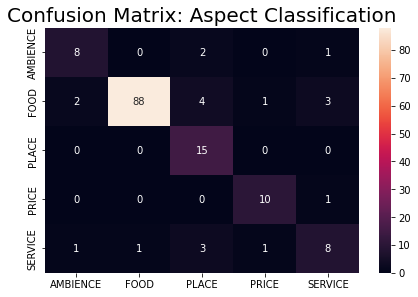

In [24]:
from sklearn.metrics import confusion_matrix
labels = ["AMBIENCE", "FOOD", "PLACE", "PRICE", "SERVICE"]
cmat = confusion_matrix(y_test, y_pred)
sns.heatmap(cmat, annot=True, xticklabels=labels, yticklabels=labels)
plt.tight_layout()
plt.title("Confusion Matrix: Aspect Classification", fontdict={"fontsize":"20"})
plt.show()

In [13]:
pickle.dump(svm, open("svm_model_v3.pkl", "wb"))

In [14]:
pickle.dump(lbl, open("label_encoded_v3.pkl", "wb"))

In [202]:
# Using XGB "no working for imbalanced class."
xgb = XGBClassifier(n_estimators=500, verbosity=0, random_state=42, scale_pos_weight=10)
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")
print(classification_report(y_test, y_pred))

/home/sarthak/Code/env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.77      0.74      0.76        23
           1       0.89      0.96      0.92       116
           2       0.00      0.00      0.00         2
           3       0.38      0.26      0.31        23
           4       0.73      0.73      0.73        15

    accuracy                           0.81       179
   macro avg       0.55      0.54      0.54       179
weighted avg       0.78      0.81      0.80       179



In [205]:
# Using RandomForest
rf = RandomForestClassifier(n_estimators=300, random_state=42, class_weight="balanced")
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.84      0.70      0.76        23
           1       0.79      1.00      0.89       116
           2       0.00      0.00      0.00         2
           3       0.83      0.22      0.34        23
           4       1.00      0.53      0.70        15

    accuracy                           0.81       179
   macro avg       0.69      0.49      0.54       179
weighted avg       0.81      0.81      0.77       179



/home/sarthak/Code/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sarthak/Code/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sarthak/Code/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [206]:
senDf = pd.read_csv("midan_odenplan_sentiments.csv")
negRev = senDf[senDf["polarity"]<0]
negRev.dropna(inplace=True)
asp = []
for row in negRev.iterrows():
    row = row[1]
    asp.extend(row["aspects"].split(", "))
#aspects = set(negRev.aspects.values)
#aspects
asp = list(set(asp))

/home/sarthak/Code/env/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [207]:
glove_embeddings = {}

with open('glove.6B/glove.6B.50d.txt', 'r') as fopen:
    for line in fopen:
        split_line = line.split()
        word = split_line[0]
        emb = np.array(split_line[1:], dtype=np.float64)
        glove_embeddings[word] = emb

word_embeddings = {}
for word in asp:
    if word in glove_embeddings.keys():
        word_embeddings[word] = glove_embeddings[word]    
    else:
        continue
        #noEmb.append(word)
        #word_embeddings[word] = (np.random.uniform(-0.25, 0.25, 50))

In [208]:
wordEmbDf = pd.DataFrame({"word":word_embeddings.keys(), "embedding":word_embeddings.values()})

In [209]:
predCategory = []
for row in wordEmbDf.iterrows():
    row = row[1]
    pred = lbl.inverse_transform(svm.predict(np.expand_dims(row["embedding"], axis=0)))
    predCategory.append(pred[0])

In [210]:
wordEmbDf["predCategory"] = predCategory

In [183]:
wordEmbDf.to_csv("aspect_classification/word_emb_df_midan.csv", index=None)

In [211]:
aspDf.cat.value_counts()

FOOD          580
RESTAURANT    115
AMBIENCE      113
SERVICE        73
LOCATION       13
Name: cat, dtype: int64

In [232]:
portions = []
labels = []
for cat in wordEmbDf.predCategory.unique():
    tmp = wordEmbDf[wordEmbDf["predCategory"]== cat]
    print(f"Category: {cat}, {round(len(tmp)/len(wordEmbDf)*100, 2)}%")
    portions.append(round(len(tmp)/len(wordEmbDf)*100, 2))
    labels.append(cat)
    for e in tmp["word"].values:
        print(e, end=", ")
    print("\n")

Category: SERVICE, 20.56%
complaint, scholars, code, people, customers, money, guys, times, priority, service, give, advice, staff, problem, sister, husband, contact, attention, hygiene, care, let, star, 

Category: AMBIENCE, 17.76%
cleanliness, aspect, importance, concept, glass, years, plastic, mean, thing, music, are, table, pity, floor, something, lot, decor, bit, experience, 

Category: RESTAURANT, 20.56%
season, price, oc, kroner, ist, prices, rate, restaurant, paper, crown, stockholm, days, raise, zero, date, order, disappointment, cost, expectations, deal, rule, place, 

Category: FOOD, 34.58%
meat, bread, leftovers, quality, kebab, seeds, tazo, waste, sandwich, pita, pomegranate, cumin, drying, food, quantity, kebabs, taste, yogurt, sauces, drink, dish, potatoes, rice, lemon, regions, seasoning, fries, chickpeas, pizza, poisoning, tahini, plate, amount, plates, falafel, shawarma, meal, 

Category: LOCATION, 6.54%
name, case, turn, places, court, portion, way, 



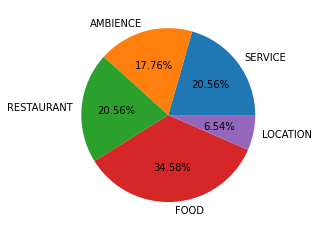

In [241]:
plt.pie(portions, labels=labels, autopct="%.2f%%")
plt.show()